
References:
    
1. Exponential smoothing tutorial https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html


SES is not meant for data with trend/seasonal patterns. Why not just make it stationary or pick another method?
https://stats.stackexchange.com/questions/239811/can-simple-exponential-forecasting-be-used-for-a-non-stationary-series


Close to 0 alpha means that weighting the most recent values higher is not improving the model. alpha=0 would be a mean of the training data (all data weighted equally in terms of importance) and would predict that mean as the forecast.

For more information see: https://www.otexts.org/fpp/7/1

In [42]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # For styling
import pandas_datareader as pdr
import datetime as dt

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt



sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()

In [43]:
stocks = ['ADVANC']
start = dt.datetime(2014,1,1)
end = dt.datetime(2018,12,31) # end is optional

df = pd.DataFrame()
dataset = {}
for s in stocks:
    try:
        data = pdr.get_data_yahoo('%s.BK' % s,start=start,end=end)
        data['ticker'] = s # add ticker to column
        data['adj_close'] = data['Adj Close']
        dataset[s] = data[['ticker', 'adj_close']] # Need two columns
        df = pd.concat([df, dataset[s]])
    except Exception as e:
        print("Error: %s %s" % (s, str(e)))


table = df.pivot(columns='ticker')
table

adj_close                                                         \
ticker          ADVANC        AOT      BANPU         BBL       BDMS       BEM   
Date                                                                            
2014-01-02  137.609299   8.198195  14.657036  128.947006   8.484464  2.094060   
2014-01-03  144.232224   8.114254  13.871892  130.889008   8.445543  2.027924   
2014-01-06  147.911621   7.974353  13.217523  134.772934   9.262852  1.983840   
2014-01-07  154.534515   8.477996  13.610131  138.268524   9.146094  2.049976   
2014-01-08  151.591019   8.114254  13.871892  137.880112   8.912578  2.027924   
...                ...        ...        ...         ...        ...       ...   
2018-12-24  163.651642  64.083893  14.114557  190.823547  25.665375  9.962773   
2018-12-25  162.228592  61.865604  13.588550  188.044571  25.181122  9.718588   
2018-12-26  161.754242  63.097988  13.500880  187.118240  25.423250  9.279055   
2018-12-27  160.805542  62.358559  13.500880  184.339264  23.728367  9.425565   
2018-12-28  163.651642  63.344463  12.974873  188.044571  24.018917  9.474402   

                                                        
ticker          BGRIM          BH        BJC       BTS  
Date                                                    
2014-01-02        NaN   73.877037  38.513458  5.908451  
2014-01-03        NaN   75.204170  37.477047  5.728316  
2014-01-06        NaN   74.319405  36.231415  5.692288  
2014-01-07        NaN   73.655846  37.058784  5.872424  
2014-01-08        NaN   72.549896  36.649673  5.800371  
...               ...         ...        ...       ...  
2018-12-24  26.334829  185.820419  51.096230  9.048749  
2018-12-25  25.842588  181.543243  48.916767  8.861211  
2018-12-26  25.842588  182.018463  49.401096  8.861211  
2018-12-27  25.596470  175.365051  48.432446  8.814325  
2018-12-28  26.088709  178.216507  49.158932  8.954980  

[1220 rows x 10 columns]

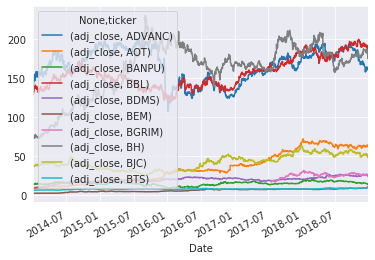

In [44]:
# df = pd.read_csv('risk-free.csv', index_col=0)
# df.set_index('Period')
# df.index = pd.to_datetime(df.index) # Make the column a datetime
df = table
df.plot()

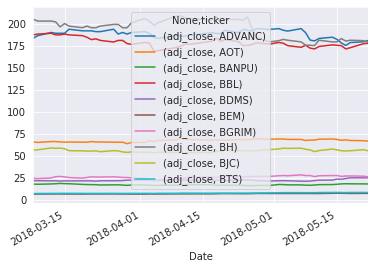

In [45]:
# Single shot routine
# Each period has 200 days. 150 days for training, 50 days for testing.

def single_shot(df, period_size=200, training_days=150, testing_days=50):
    training_idx = df.index[-period_size: -training_days]
    testing_idx = df.index[-training_days:]
    training = df[-period_size: -training_days]
    testing = df[-training_days:]
    return training, testing

training, testing = single_shot(df)

training.plot()

In [46]:
# Walk forward routine
# Each period has 200 days. 150 days for training, 50 days for testing.

def walk_forward(df, period_size = 200, training_days=150, testing_days=50):
    assert(len(df.index) > period_size) # Dataframe must be longer than period size
    
    datasets = {}
    
    # Day first:
    df.index[0]
    # Day last:
    df.index[-period_size]
    # Datasets to generate
    firstdays = df.index[0:-200]
    for i, d in enumerate(firstdays):
        c = i - 1 # Start df index at 0
        start = c
        end = c + period_size
        # training_idx = df.index[start: start+training_days]
        # testing_idx = df.index[start+training_days:end] 
        training = df[start : start+training_days]
        testing = df[start+training_days : end]           
        # yield d, training, testing
        datasets[d] = (i, training, testing)
    return datasets
# training, testing = walk_forward(df)


In [47]:
ds = walk_forward(df)

In [48]:
# Pick the train test set.


list(ds.keys())[-1]

Timestamp('2018-03-07 00:00:00')

1019

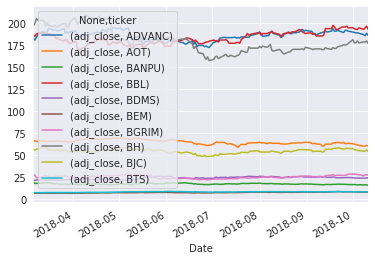

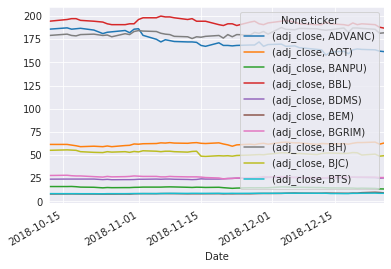

In [49]:
set_id, training, test = ds[list(ds.keys())[-1]]


training.plot()
test.plot()
set_id

# Simple Exponential Smoothing

Lets use Simple Exponential Smoothing to forecast the data.

Forecast three periods ahead. Shows trend from SES model with params.

- Need to resample to Day frequency.
- Error if there is gap in the series.

# Single Stock Data


One example set from walk-forward routine.

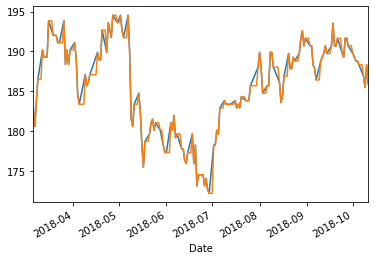

In [9]:
# Pick stock


stock1 = training[training.columns[0]] # Pick first series in dataframe
stock1.plot()

# stock1 = stock1.resample('D').mean()
# stock1.plot()

# Set frequency: backfill method  bfill or ffill
stock1 = stock1.asfreq('d', method='ffill') # Resample frequency to daily
stock1.plot()
# stock1.resample('M').plot()
# stock1.index.freq

In [10]:
# Model

fit1 = SimpleExpSmoothing(stock1).fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(30).rename(r'$\alpha=0.2$')
fit2 = SimpleExpSmoothing(stock1).fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(30).rename(r'$\alpha=0.6$')
fit3 = SimpleExpSmoothing(stock1).fit()
fcast3 = fit3.forecast(30).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])


In [11]:
fit1.fittedvalues

Date
2018-03-06    182.864975
2018-03-07    182.864975
2018-03-08    182.407816
2018-03-09    182.682115
2018-03-10    183.450147
                 ...    
2018-10-07    189.249455
2018-10-08    189.063159
2018-10-09    188.629513
2018-10-10    187.997983
2018-10-11    188.061982
Freq: D, Length: 220, dtype: float64

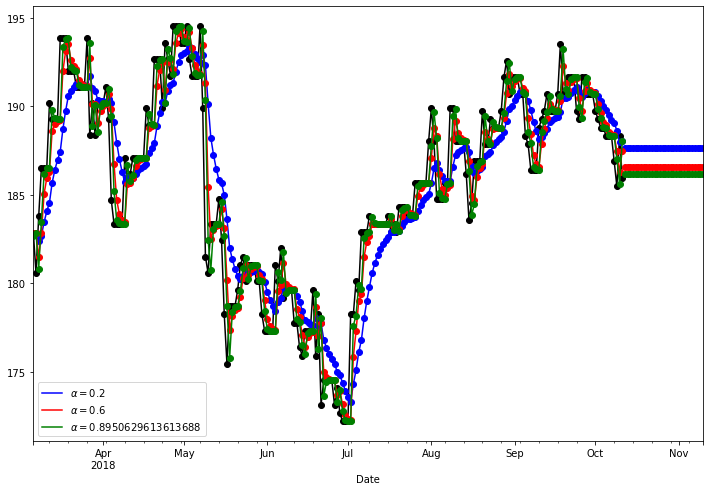

In [12]:
ax = stock1.plot(marker='o', color='black', figsize=(12,8))
fcast1.plot(marker='o', ax=ax, color='blue', legend=True)
fit1.fittedvalues.plot(marker='o', ax=ax, color='blue')
fcast2.plot(marker='o', ax=ax, color='red', legend=True)

fit2.fittedvalues.plot(marker='o', ax=ax, color='red')
fcast3.plot(marker='o', ax=ax, color='green', legend=True)
fit3.fittedvalues.plot(marker='o', ax=ax, color='green')
plt.show()

In [13]:
fit1.sse, fit2.sse, fit3.sse

(1409.4144823935742, 729.0194804344147, 670.0087165446188)

In [14]:
stock1.index[0]

Timestamp('2018-03-06 00:00:00', freq='D')

In [15]:
stock1.index[-1]

Timestamp('2018-10-11 00:00:00', freq='D')

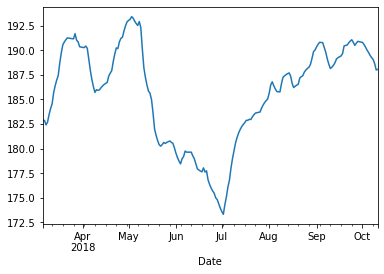

In [16]:
fit1.fittedvalues.plot()

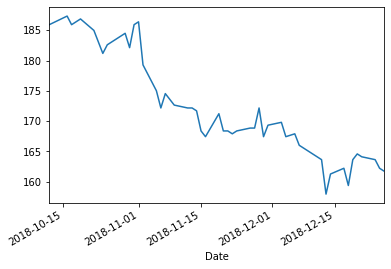

In [17]:
stock1_val = test[test.columns[0]]
stock1_val.plot()

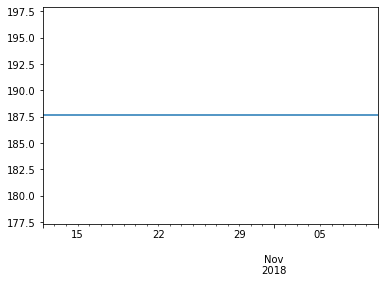

In [18]:
fcast1.plot()

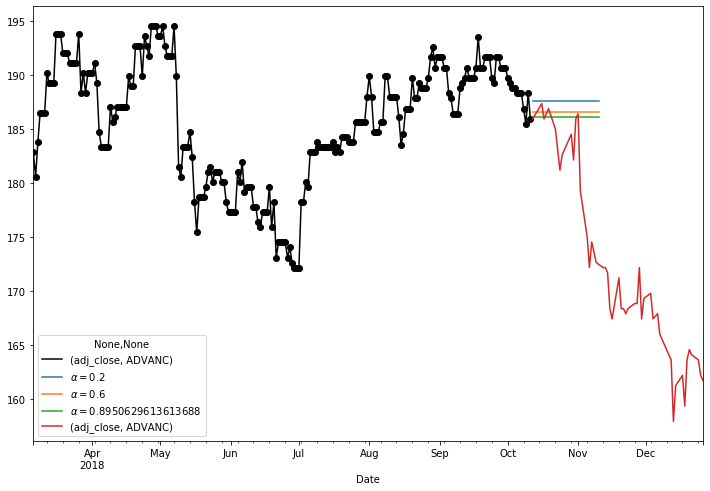

In [19]:
ax = stock1.plot(marker='o', color='black', figsize=(12,8), legend=True)
fcast1.plot(ax=ax, legend=True)
fcast2.plot(ax=ax, legend=True)
fcast3.plot(ax=ax, legend=True)

stock1_val.plot(ax=ax, legend=True)

plt.show()

In [20]:
# TODO:
#  Calculate error
#  Parameters 

# df = pd.DataFrame

In [21]:
# TODO:
#  Forcast returns

# Forecast Stock Returns

In [22]:
ds = walk_forward(df)

# Select last set

set_id, training, test = ds[list(ds.keys())[-1]]
set_id, training.index[0], test.index[-1] # Set ID. Start. End.

(1019, Timestamp('2018-03-06 00:00:00'), Timestamp('2018-12-26 00:00:00'))

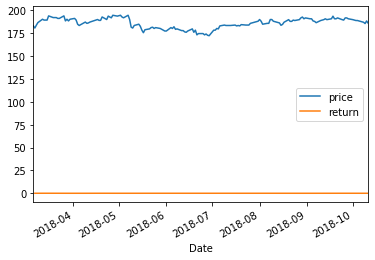

In [30]:
returns = training.pct_change()

prices = training[training.columns[0]]
returns = returns[returns.columns[0]] # First stock
# returns.plot()
returns = returns.dropna() # Drop NaN

forecast_df = pd.DataFrame({'price': prices, 'return': returns})
forecast_df.plot()


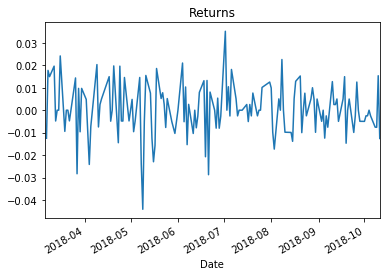

In [31]:
forecast_df['return'].plot(title='Returns')

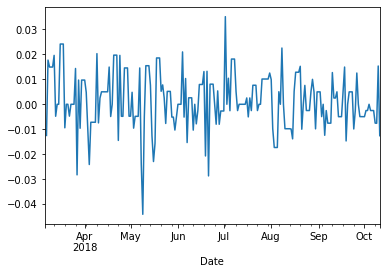

In [32]:
return1 = forecast_df['return'].asfreq('d', method='ffill')
return1.plot()

In [33]:
# Model

rfit1 = SimpleExpSmoothing(return1).fit(smoothing_level=0.2,optimized=False)
rfcast1 = rfit1.forecast(30).rename(r'$\alpha=0.2$')
rfit2 = SimpleExpSmoothing(return1).fit(smoothing_level=0.6,optimized=False)
rfcast2 = rfit2.forecast(30).rename(r'$\alpha=0.6$')
rfit3 = SimpleExpSmoothing(return1).fit()
rfcast3 = rfit3.forecast(30).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [40]:
rfit1.fittedvalues

Date
2018-03-06   NaN
2018-03-07   NaN
2018-03-08   NaN
2018-03-09   NaN
2018-03-10   NaN
              ..
2018-10-07   NaN
2018-10-08   NaN
2018-10-09   NaN
2018-10-10   NaN
2018-10-11   NaN
Freq: D, Length: 220, dtype: float64

In [38]:
rfit3.forecast(2)

2018-10-12   NaN
2018-10-13   NaN
Freq: D, dtype: float64

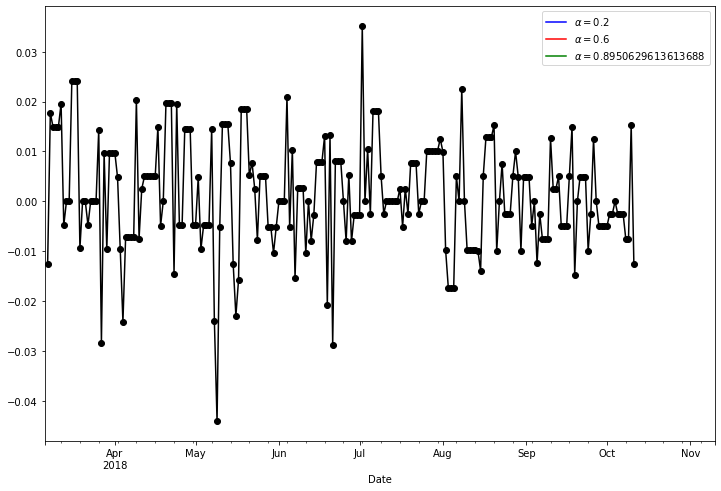

In [39]:
ax = return1.plot(marker='o', color='black', figsize=(12,8))
rfcast1.plot(marker='o', ax=ax, color='blue', legend=True)
rfit1.fittedvalues.plot(marker='o', ax=ax, color='blue')
rfcast2.plot(marker='o', ax=ax, color='red', legend=True)

rfit2.fittedvalues.plot(marker='o', ax=ax, color='red')
rfcast3.plot(marker='o', ax=ax, color='green', legend=True)
rfit3.fittedvalues.plot(marker='o', ax=ax, color='green')
plt.show()